# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV136"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv136')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv136/lv136-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 16:00:16,707 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
575,KEGG_ECM_RECEPTOR_INTERACTION,136,0.799754,4.564191e-06,0.000073
576,REACTOME_MUSCLE_CONTRACTION,136,0.751250,2.318938e-03,0.014931
577,REACTOME_COLLAGEN_FORMATION,136,0.870741,1.437195e-05,0.000200
580,PID_INTEGRIN1_PATHWAY,136,0.883285,4.595639e-07,0.000009


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP063867, SRP042597, SRP047082, SRP038863, SRP049593, SRP055569, SRP018218, SRP039348, SRP067469, SRP056146, SRP053366, SRP048889, SRP058375, SRP049714, SRP041573, SRP021134, SRP042212, SRP033135, SRP042186, SRP051772, SRP049004, SRP041063, SRP043644, SRP064259, SRP063889, SRP049409, SRP043162, SRP047516, SRP032942, SRP033569, SRP045222, SRP017631, SRP037762, SRP049340, SRP019374, SRP032363, SRP063059, SRP039598, SRP050397, SRP043166, SRP044271, SRP057156, SRP004637, SRP007461, SRP033250, SRP051599, SRP019994, SRP027383, SRP034634, SRP047339, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (49 != 50)
  warnings.warn(


In [19]:
lv_data.shape

(2794, 81)

In [20]:
lv_data.head()

data set   cell type cell subtype disease/genotype  \
project   run                                                              
SRP063867 SRR2453324  isogenic         ESC          NaN              NaN   
          SRR2453325  isogenic         ESC          NaN              NaN   
          SRR2453323  isogenic  Fibroblast          NaN              NaN   
          SRR2453321  isogenic         ESC          NaN              NaN   
          SRR2453322  isogenic         ESC          NaN              NaN   

                     genotype source cell type time point cell line  \
project   run                                                         
SRP063867 SRR2453324      NaN              NaN        NaN       NaN   
          SRR2453325      NaN              NaN        NaN       NaN   
          SRR2453323      NaN              NaN        NaN       NaN   
          SRR2453321      NaN              NaN        NaN       NaN   
          SRR2453322      NaN              NaN        NaN       NaN   

                     sequenced molecule gender  ... sample pool name  \
project   run                                   ...                    
SRP063867 SRR2453324                NaN    NaN  ...              NaN   
          SRR2453325                NaN    NaN  ...              NaN   
          SRR2453323                NaN    NaN  ...              NaN   
          SRR2453321                NaN    NaN  ...              NaN   
          SRR2453322                NaN    NaN  ...              NaN   

                     sample type tissue harvest site population doublings  \
project   run                                                               
SRP063867 SRR2453324         NaN                 NaN                  NaN   
          SRR2453325         NaN                 NaN                  NaN   
          SRR2453323         NaN                 NaN                  NaN   
          SRR2453321         NaN                 NaN                  NaN   
          SRR2453322         NaN                 NaN                  NaN   

                     tissue archive method subtypes history hypoxia exposure  \
project   run                                                                  
SRP063867 SRR2453324                   NaN      NaN     NaN              NaN   
          SRR2453325                   NaN      NaN     NaN              NaN   
          SRR2453323                   NaN      NaN     NaN              NaN   
          SRR2453321                   NaN      NaN     NaN              NaN   
          SRR2453322                   NaN      NaN     NaN              NaN   

                     cell cycle stage     LV136  
project   run                                    
SRP063867 SRR2453324              NaN  0.001449  
          SRR2453325              NaN  0.000810  
          SRR2453323              NaN  0.922192  
          SRR2453321              NaN  0.009537  
          SRR2453322              NaN  0.010631  

[5 rows x 81 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

library-type             0.149960
spike-in                 0.149960
gender                   0.149251
genotype                 0.147590
donor                    0.142041
data set                 0.101910
sequenced molecule       0.096388
condition/treatment      0.091796
strain                   0.091796
localication             0.085065
time of analysis         0.085065
cell subtype             0.084495
disease/genotype         0.084495
source cell type         0.084495
time point               0.084495
source                   0.057141
fusion type              0.055843
age (months)             0.055843
differentiation stage    0.054837
cell line                0.040376
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell subtype    0.084495
tissue          0.029873
cell type       0.027465
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "cell subtype",
        "tissue",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type                                cell subtype  \
project   run                                                                  
SRP063867 SRR2453302  Fibroblast                                         NaN   
          SRR2453307  Fibroblast                                         NaN   
SRP042597 SRR1304100         NaN               mesenchymal stem cells (MSCs)   
          SRR1304096         NaN               mesenchymal stem cells (MSCs)   
          SRR1304098         NaN  mesenchymal stem cells (MSCs) intermediate   
SRP047082 SRR1574529  Fibroblast                                         NaN   
SRP042597 SRR1304102         NaN  mesenchymal stem cells (MSCs) intermediate   
SRP047082 SRR1574528  Fibroblast                                         NaN   
SRP042597 SRR1304099         NaN                                  osteoblast   
SRP063867 SRR2453320  Fibroblast                                         NaN   
          SRR2453319  Fibroblast                                         NaN   
SRP042597 SRR1304103         NaN                                  osteoblast   
SRP038863 SRR1175193         NaN                                         NaN   
          SRR1175211         NaN                                         NaN   
SRP042597 SRR1304097         NaN  mesenchymal stem cells (MSCs) intermediate   
SRP049593 SRR1643504         NaN                                         NaN   
          SRR1643497         NaN                                         NaN   
          SRR1643500         NaN                                         NaN   
          SRR1643512         NaN                                         NaN   
          SRR1643505         NaN                                         NaN   
          SRR1643513         NaN                                         NaN   
          SRR1643511         NaN                                         NaN   
          SRR1643506         NaN                                         NaN   
          SRR1643503         NaN                                         NaN   
SRP038863 SRR1175208         NaN                                         NaN   

                     tissue     LV136  
project   run                          
SRP063867 SRR2453302    NaN  1.214808  
          SRR2453307    NaN  1.174256  
SRP042597 SRR1304100    NaN  1.166721  
          SRR1304096    NaN  1.137275  
          SRR1304098    NaN  1.118370  
SRP047082 SRR1574529    NaN  1.068360  
SRP042597 SRR1304102    NaN  1.068302  
SRP047082 SRR1574528    NaN  1.029498  
SRP042597 SRR1304099    NaN  1.002788  
SRP063867 SRR2453320    NaN  0.996606  
          SRR2453319    NaN  0.986281  
SRP042597 SRR1304103    NaN  0.972058  
SRP038863 SRR1175193    NaN  0.949986  
          SRR1175211    NaN  0.948702  
SRP042597 SRR1304097    NaN  0.947099  
SRP049593 SRR1643504    NaN  0.946274  
          SRR1643497    NaN  0.945724  
          SRR1643500    NaN  0.945644  
          SRR1643512    NaN  0.944602  
          SRR1643505    NaN  0.943546  
          SRR1643513    NaN  0.943382  
          SRR1643511    NaN  0.943323  
          SRR1643506    NaN  0.943300  
          SRR1643503    NaN  0.941668  
SRP038863 SRR1175208    NaN  0.940527

In [26]:
# what is there in these projects?
lv_data.loc[["SRP067469"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

donor  \
project   run                                
SRP067469 SRR3021901  female, 41y, healthy   
          SRR3021902  female, 68y, healthy   
          SRR3021904  female, 41y, healthy   
          SRR3021900    male, 48y, healthy   
          SRR3021905  female, 68y, healthy   
          SRR3021903    male, 48y, healthy   
          SRR3021907  female, 41y, healthy   
          SRR3021906    male, 48y, healthy   
          SRR3021908  female, 68y, healthy   

                                          time of analysis   localication  \
project   run                                                               
SRP067469 SRR3021901         directly after trypsinisation       in vitro   
          SRR3021902         directly after trypsinisation       in vitro   
          SRR3021904                      1h after thawing       in vitro   
          SRR3021900         directly after trypsinisation       in vitro   
          SRR3021905                      1h after thawing       in vitro   
          SRR3021903                      1h after thawing       in vitro   
          SRR3021907  2h after infusion of trypsinised MSC  in mouse lung   
          SRR3021906  2h after infusion of trypsinised MSC  in mouse lung   
          SRR3021908  2h after infusion of trypsinised MSC  in mouse lung   

                         LV136  
project   run                   
SRP067469 SRR3021901  0.755722  
          SRR3021902  0.715122  
          SRR3021904  0.657066  
          SRR3021900  0.593703  
          SRR3021905  0.580828  
          SRR3021903  0.552265  
          SRR3021907  0.134767  
          SRR3021906  0.046490  
          SRR3021908  0.045547

**No cell types/tissues/cell lines** so not very interesting

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["cell subtype", "tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV136
project   run                                                             
SRP063867 SRR2453302                                  Fibroblast  1.214808
          SRR2453307                                  Fibroblast  1.174256
SRP042597 SRR1304100               mesenchymal stem cells (MSCs)  1.166721
          SRR1304096               mesenchymal stem cells (MSCs)  1.137275
          SRR1304098  mesenchymal stem cells (MSCs) intermediate  1.118370
SRP047082 SRR1574529                                  Fibroblast  1.068360
SRP042597 SRR1304102  mesenchymal stem cells (MSCs) intermediate  1.068302
SRP047082 SRR1574528                                  Fibroblast  1.029498
SRP042597 SRR1304099                                  osteoblast  1.002788
SRP063867 SRR2453320                                  Fibroblast  0.996606
          SRR2453319                                  Fibroblast  0.986281
SRP042597 SRR1304103                                  osteoblast  0.972058
SRP038863 SRR1175193                             NOT CATEGORIZED  0.949986
          SRR1175211                             NOT CATEGORIZED  0.948702
SRP042597 SRR1304097  mesenchymal stem cells (MSCs) intermediate  0.947099
SRP049593 SRR1643504                             NOT CATEGORIZED  0.946274
          SRR1643497                             NOT CATEGORIZED  0.945724
          SRR1643500                             NOT CATEGORIZED  0.945644
          SRR1643512                             NOT CATEGORIZED  0.944602
          SRR1643505                             NOT CATEGORIZED  0.943546

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # General
            "adipocyte": "Adipocytes",
            "Fibroblast": "Fibroblasts",
            "fibroblast": "Fibroblasts",
            "fibroblasts": "Fibroblasts",
            "Cultured foreskin fibroblast cells (Stegment)": "Fibroblasts",
            "Primary fibroblasts": "Fibroblasts",
            "osteoblast": "Osteoblasts",
            "osteoblasts": "Osteoblasts",
            "Osteoblast": "Osteoblasts",
            "mesenchymal stem cells (MSCs) intermediate": "Mesenchymal stem cells",
            "mesenchymal stem cells (MSCs)": "Mesenchymal stem cells",
            "Mesenchymal stem cell": "Mesenchymal stem cells",
            "MPC": "Mesenchymal progenitor cells (adipogenic media)",
            "Human Kupffer cells": "Kupffer cells",
            "human pancreatic stellate cells": "Pancreatic stellate cells",
            "BAT": "Brown adipose tissue",
            "WAT": "White adipose tissue",
            "human coronary artery smooth muscle cells (HCASMCs)": "Coronary artery smooth muscle cells (HCASMCs)",
            # SRP055569
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
        }
    }
)

# plot_data = plot_data[plot_data[SELECTED_ATTRIBUTE] != "no cell"]

In [34]:
# add also tissue information to these projects
_srp_code = "SRP048889"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


_srp_code = "SRP034634"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'hypoxia exposure']})",
    axis=1,
)
_tmp = _tmp.replace(
    "human pulmonary microvascular endothelial cells \((24|48) hours\)",
    "Pulmonary microvascular endothelial cells (hypoxia stress)",
    regex=True,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-441a99eaf6ca>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-34-441a99eaf6ca>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# all samples from SRP049593 are fibroblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Fibroblasts"
    if x.name[0] in ("SRP049593", "SRP017631")
    else x["cell type"],
    axis=1,
)

In [36]:
# all samples from SRP038863 are human osteoblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Osteoblasts" if x.name[0] == "SRP038863" else x["cell type"],
    axis=1,
)

In [37]:
# all samples from SRP067469 are mesenchymal stromal cells from adipose tissue
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Mesenchymal stem cells" if x.name[0] == "SRP067469" else x["cell type"],
    axis=1,
)

In [38]:
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Mesenchymal cells (stromal vascular / adipose tissue)"
    if x.name[0] == "SRP063889"
    else x["cell type"],
    axis=1,
)

In [39]:
# all samples from SRP058375 are Kupffer cells
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Kupffer cells" if x.name[0] == "SRP058375" else x["cell type"],
    axis=1,
)

In [40]:
# all samples from SRP049004 are fibroblastas
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Dermal fibroblasts"
    if x.name[0] in ("SRP058375", "SRP049004")
    else x["cell type"],
    axis=1,
)

In [41]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [42]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [43]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [44]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [45]:
len(attr_order)

25

In [46]:
attr_order[:5]

['Fibroblasts',
 'Mesenchymal stem cells',
 'Osteoblasts',
 'Glioma cells + lung fibroblast cells',
 'Pancreatic stellate cells']

## Plot

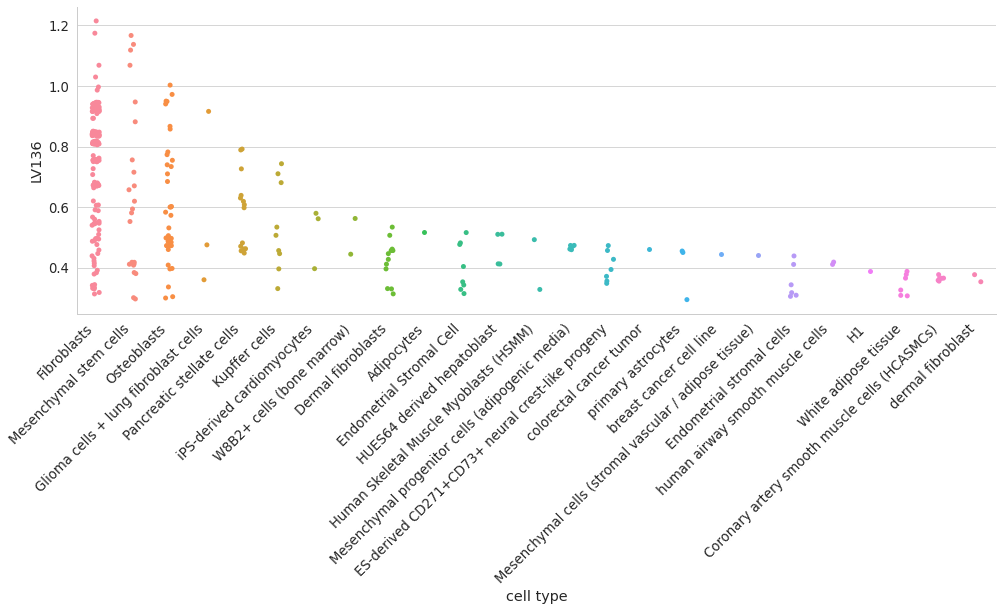

In [47]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [48]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [49]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)